# LLC4320 Global Rotarty Spectrum

In [1]:
import dask

In [126]:
from dask.distributed import Client

client = Client("tcp://10.32.78.25:44015")
client

Client Scheduler: tcp://10.32.78.25:44015 Dashboard: /user/0000-0001-5999-4917/proxy/8787/status,Cluster Workers: 5 Cores: 10 Memory: 57.50 GB


In [2]:
dask.config.config

{'distributed': {'logging': {'bokeh': 'critical'},
  'dashboard': {'link': '/user/{JUPYTERHUB_USER}/proxy/{port}/status'},
  'admin': {'tick': {'limit': '5s'}}},
 'kubernetes': {'name': 'dask-{JUPYTERHUB_USER}-{uuid}',
  'count': {'max': 30},
  'worker-template': {'metadata': None,
   'spec': {'restartPolicy': 'Never',
    'containers': [{'args': ['dask-worker',
       '--nthreads',
       '2',
       '--no-bokeh',
       '--memory-limit',
       '11.5GB',
       '--death-timeout',
       '60'],
      'image': '${JUPYTER_IMAGE_SPEC}',
      'name': 'dask-${JUPYTERHUB_USER}',
      'resources': {'limits': {'cpu': 16, 'memory': '11.5G'},
       'requests': {'cpu': 1, 'memory': '11.5G'}}}]}}},
 'labextension': {'factory': {'module': 'dask_kubernetes',
   'class': 'KubeCluster',
   'args': [],
   'kwargs': {}}},
 'temporary-directory': None,
 'array': {'svg': {'size': 120}}}

In [4]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import xgcm
import xrft
%matplotlib inline

### Create and Connect to Dask Cluster

I am using a very big cluster to make it go fast.

### Open and Merge Data

In [105]:
import intake
cat = intake.Catalog('https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/llc4320.yaml')
ds_grid = cat.LLC4320_grid.to_dask().reset_coords()
ds_grid = ds_grid.drop(['k_p1','Zp1', 'Zl', 'PHrefF', 'drC'])
ds_U = cat.LLC4320_SSU(chunks=None).to_dask()
ds_V = cat.LLC4320_SSV(chunks=None).to_dask()

In [106]:
ds = xr.merge([ds_U, ds_V])
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 9030)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-23T05:00:00
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    U        (time, face, j, i_g) float32 ...
    V        (time, face, j_g, i) float32 ...

In [107]:
# slice in time first and then chunk in order to avoid enormous graph
NT = 2 # vary up to 9030 to make problem bigger
ds = ds.isel(time=slice(0, NT)).chunk({'time': 1, 'face': 1})
ds

<xarray.Dataset>
Dimensions:  (face: 13, i: 4320, i_g: 4320, j: 4320, j_g: 4320, time: 2)
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * time     (time) datetime64[ns] 2011-09-13 2011-09-13T01:00:00
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
Data variables:
    U        (time, face, j, i_g) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>
    V        (time, face, j_g, i) float32 dask.array<chunksize=(1, 1, 4320, 4320), meta=np.ndarray>

In [108]:
from xmitgcm.llcreader.llcmodel import faces_dataset_to_latlon

# rechunk to full latlon faces (huge!)
chunks = {'i': -1, 'j': -1, 'i_g': -1, 'j_g': -1}

ds_ll = faces_dataset_to_latlon(ds, metric_vector_pairs=[]).chunk(chunks)
ds_ll
ds_grid_ll = faces_dataset_to_latlon(ds_grid).chunk(chunks)

In [109]:
ds_ll.U.data

dask.array<rechunk-merge, shape=(2, 12960, 17280), dtype=float32, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>

In [110]:
from numba import jit, guvectorize

@jit(nopython=True)
def diff_x_right(f):
    ny, nx = f.shape
    g = np.ones_like(f)
    for j in range(ny):
        j_next = j
        for i in range(nx):
            i_next = (i + 1) % nx
            g[j, i] = -f[j, i] + f[j_next, i_next]
    return g

@jit(nopython=True)
def diff_y_right(f):
    ny, nx = f.shape
    g = np.ones_like(f)
    for j in range(ny):
        j_next = (j + 1) % ny
        for i in range(nx):
            i_next = i
            g[j, i] = -f[j, i] + f[j_next, i_next]
    return g

@jit(nopython=True)
def diff_x_left(f):
    ny, nx = f.shape
    g = np.ones_like(f)
    for j in range(ny):
        j_next = j
        for i in range(nx):
            i_next = (i - 1) % nx
            g[j, i] = f[j, i] - f[j_next, i_next]
    return g

@jit(nopython=True)
def diff_y_left(f):
    ny, nx = f.shape
    g = np.ones_like(f)
    for j in range(ny):
        j_next = (j - 1) % ny
        for i in range(nx):
            i_next = i
            g[j, i] = f[j, i] - f[j_next, i_next]
    return g

sig = "Tuple((float32[:,:], float32[:,:]))(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],int64,float32[:,:],int64,int64)"
@jit(sig, nopython=True)
def smooth_numba(U, V, dxF, dxV, dyF, dyU, rAw, rAs, c11, c12, c21, c22, DT):

    tau_11 = c11 * dxF**-1 * diff_x_right(U)
    tau_12 = c12 * dyU**-1 * diff_y_left(U)
    tau_21 = c21 * dxV**-1 * diff_x_left(V)
    tau_22 = c22 * dxF**-1 * diff_y_right(V)

    # we neglect land completely, as Hussein recommends
    G_u = (diff_x_left(dyF * tau_11)
           + diff_x_right(dxV * tau_12)) / rAw
    G_v = (diff_y_right(dyU * tau_21)
           + diff_y_left(dxF * tau_22)) / rAs

    # step forward
    U_sm = U + DT * G_u
    V_sm = V + DT * G_v
    
    return U_sm, V_sm

@jit(nopython=True)
def iterate_numba(U, V, dxF, dxV, dyF, dyU, rAw, rAs, c11, c12, c21, c22, DT, niters):
    for n in range(niters):
        U, V = smooth_numba(U, V, dxF, dxV, dyF, dyU, rAw, rAs, c11, c12, c21, c22, DT)
    return U, V

In [120]:
# https://github.com/numba/numba/issues/4314   
    
def cp_guvectorize(*args, **kwargs):
    """Same as :func:`numba.guvectorize`, but can be used to decorate dynamically
    defined function and then pickle them with
    `cloudpickle <https://pypi.org/project/cloudpickle/>`_.
    On the other hand, it can't be called from another jit-compiled function.
    """

    def decorator(func):
        return _PickleableGUVectorized(func, args, kwargs)

    return decorator


class _PickleableGUVectorized:
    def __init__(self, func, guvectorize_args, guvectorize_kwargs):
        self.args = func, guvectorize_args, guvectorize_kwargs
        decorator = guvectorize(*guvectorize_args, **guvectorize_kwargs)
        self.ufunc = decorator(func)

    def __reduce__(self):
        return _PickleableGUVectorized, self.args

    def __call__(self, *args, **kwargs):
        return self.ufunc(*args, **kwargs)

In [121]:
# sig for smooth numba
ftylist = "(float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],float32[:,:],int64,float32[:,:],int64,int64,float32[:,:],float32[:,:])"

ufunc_sig = 8 * '(j, i), ' + '(j, i), (), (j, i), (), () -> (j, i), (j, i)'

@cp_guvectorize(ftylist, ufunc_sig)
def smooth_gu(U, V, dxF, dxV, dyF, dyU, rAw, rAs, c11, c12, c21, c22, DT, U_out, V_out):
    U_out[:], V_out[:] = smooth_numba(U, V, dxF, dxV, dyF, dyU, rAw, rAs, c11, c12, c21, c22, DT)

In [122]:
# construct missing intermediate metrics
dxC = ds_grid_ll.dxC
dxG = ds_grid_ll.dxG
dxF = grid.interp(dxC, 'X').chunk({'i': -1, 'j': -1})
dxV = grid.interp(dxG, 'X').chunk({'i_g': -1, 'j_g': -1})
dyC = ds_grid_ll.dyC
dyG = ds_grid_ll.dyG
dyF = grid.interp(dyC, 'Y', boundary='extend').chunk({'i': -1, 'j': -1})
dyU = grid.interp(dyG, 'Y', boundary='extend').chunk({'i_g': -1, 'j_g': -1})

# coefficients
Ah = 1
c11 = np.cos(np.deg2rad(ds_grid_ll.YC))**(3/2)
c21 = np.cos(np.deg2rad(ds_grid_ll.YG))**(3/2)
c12 = c22 = 1

In [123]:
L = ds_grid_ll.dyC.max().values.item()
DT = 0.05 * L**2

In [114]:
args = [a.data if isinstance(a, xr.DataArray) else a for a in
        [ds_ll.U, ds_ll.U, dxF, dxV, dyF, dyU,
         ds_grid_ll.rAw, ds_grid_ll.rAs,
         c11, c12, c21, c22, DT]
        ]
args

[dask.array<rechunk-merge, shape=(2, 12960, 17280), dtype=float32, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>,
 dask.array<rechunk-merge, shape=(2, 12960, 17280), dtype=float32, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>,
 dask.array<rechunk-merge, shape=(12960, 17280), dtype=float32, chunksize=(12960, 17280), chunktype=numpy.ndarray>,
 dask.array<rechunk-merge, shape=(12960, 17280), dtype=float32, chunksize=(12960, 17280), chunktype=numpy.ndarray>,
 dask.array<rechunk-merge, shape=(12960, 17280), dtype=float32, chunksize=(12960, 17280), chunktype=numpy.ndarray>,
 dask.array<rechunk-merge, shape=(12960, 17280), dtype=float32, chunksize=(12960, 17280), chunktype=numpy.ndarray>,
 dask.array<rechunk-merge, shape=(12960, 17280), dtype=float32, chunksize=(12960, 17280), chunktype=numpy.ndarray>,
 dask.array<rechunk-merge, shape=(12960, 17280), dtype=float32, chunksize=(12960, 17280), chunktype=numpy.ndarray>,
 dask.array<pow, shape=(12960, 17280), dtype=float32, chunks

In [127]:
U_sm, V_sm = smooth_gu(*args, output_dtypes=('f4', 'f4'))
U_sm

dask.array<transpose, shape=(2, 12960, 17280), dtype=float32, chunksize=(1, 12960, 17280), chunktype=numpy.ndarray>

In [128]:
U_sm.mean().compute()

KilledWorker: ("('smooth_gu-smooth_gu_0-mean_chunk-589841b92d1be9ce8d81b741477f1c6e', 1, 0, 0)", <Worker 'tcp://10.32.4.5:43307', memory: 0, processing: 1>)

In [ ]:
@numba.guvectorize(
    [(numba.int8[:, :], numba.int8[:, :])],
    '(n, m) -> (n, m)'
)

In [20]:
iterate_numba

CPUDispatcher(<function iterate_numba at 0x7f22b3fa0d90>)

In [17]:
# coefficients
Ah = 1
c11 = np.cos(np.deg2rad(ds_grid.YC))**(3/2)
c21 = np.cos(np.deg2rad(ds_grid.YG))**(3/2)
c12 = c22 = 1

<xarray.DataArray 'YC' (face: 13, j: 4320, i: 4320)>
dask.array<pow, shape=(13, 4320, 4320), dtype=float32, chunksize=(1, 4320, 4320), chunktype=numpy.ndarray>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

In [ ]:
iterate_numba()

In [30]:
import xgcm
grid = xgcm.Grid(ds_ll, periodic=['X', 'Y'])
grid

<xgcm.Grid>
Y Axis (periodic):
  * center   j --> left
  * left     j_g --> center
T Axis (not periodic):
  * center   time
X Axis (periodic):
  * center   i --> left
  * left     i_g --> center

In [46]:
%time ds.U.mean().load()

CPU times: user 34.4 ms, sys: 3.56 ms, total: 38 ms
Wall time: 4.27 s


<xarray.DataArray 'U' ()>
array(0.00656977, dtype=float32)

In [10]:
zeta = (-grid.diff(ds.U * ds_grid.dxC, 'Y', boundary='extend') +
         grid.diff(ds.V * ds_grid.dyC, 'X', boundary='extend')) / ds_grid.rAz
zeta

<xarray.DataArray (time: 5, face: 13, j_g: 4320, i_g: 4320)>
dask.array<truediv, shape=(5, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 4319, 4319), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-09-13T04:00:00
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

In [24]:
# divergence

div_uv = (grid.diff(ds.U * ds_grid.dyG, 'X', boundary='extend') + 
          grid.diff(ds.V * ds_grid.dxG, 'Y', boundary='extend')) / ds_grid.rA
div_uv

<xarray.DataArray (time: 5, face: 13, j: 4320, i: 4320)>
dask.array<truediv, shape=(5, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 4319, 4319), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-09-13T04:00:00
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

In [31]:
zeta.chunk({'i_g': 4320})

<xarray.DataArray (time: 5, face: 13, j_g: 4320, i_g: 4320)>
dask.array<rechunk-merge, shape=(5, 13, 4320, 4320), dtype=float32, chunksize=(1, 1, 4319, 4320), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2011-09-13T04:00:00
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * j_g      (j_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * i_g      (i_g) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

In [40]:
from xhistogram.xarray import histogram

vort_bins = np.linspace(-1e-4, 1e-4, 100)
div_bins = np.linspace(-1e-4, 1e-4, 100)

# need to rechunk to uniform size
chunks = {'i': 4320, 'j': 4320}

vort_div_hist = histogram(zeta.rename('vorticity').rename({'j_g': 'j', 'i_g': 'i'}).chunk(chunks),
                          div_uv.rename('divergence').chunk(chunks),
                          bins=[vort_bins, div_bins],
                          dim=['i', 'j', 'face'])
vort_div_hist

<xarray.DataArray 'histogram_vorticity_divergence' (time: 5, vorticity_bin: 99, divergence_bin: 99)>
dask.array<getitem, shape=(5, 99, 99), dtype=int64, chunksize=(1, 99, 99), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 2011-09-13 ... 2011-09-13T04:00:00
  * vorticity_bin   (vorticity_bin) float64 -9.899e-05 -9.697e-05 ... 9.899e-05
  * divergence_bin  (divergence_bin) float64 -9.899e-05 -9.697e-05 ... 9.899e-05

In [41]:
vort_div_hist.load()

<xarray.DataArray 'histogram_vorticity_divergence' (time: 5, vorticity_bin: 99, divergence_bin: 99)>
array([[[29, 39, 42, ..., 23, 17, 20],
        [41, 46, 45, ..., 21, 23, 11],
        [46, 41, 36, ..., 21, 22, 25],
        ...,
        [38, 30, 37, ..., 15, 34, 27],
        [32, 32, 31, ..., 32, 25, 22],
        [31, 34, 34, ..., 23, 21, 23]],

       [[29, 44, 42, ..., 25, 19, 25],
        [43, 43, 38, ..., 29, 34, 22],
        [28, 46, 44, ..., 28, 28, 18],
        ...,
        [32, 37, 32, ..., 30, 27, 17],
        [29, 30, 37, ..., 23, 30, 22],
        [30, 32, 36, ..., 31, 32, 17]],

       [[27, 42, 39, ..., 15, 20, 20],
        [31, 35, 43, ..., 26, 31, 22],
        [47, 36, 50, ..., 37, 24, 24],
        ...,
        [26, 31, 37, ..., 29, 19, 19],
        [37, 31, 33, ..., 27, 26, 27],
        [23, 39, 33, ..., 26, 21, 25]],

       [[24, 39, 45, ..., 19, 20, 24],
        [29, 34, 52, ..., 18, 17, 30],
        [31, 41, 48, ..., 26, 21, 17],
        ...,
        [25, 40, 24, .

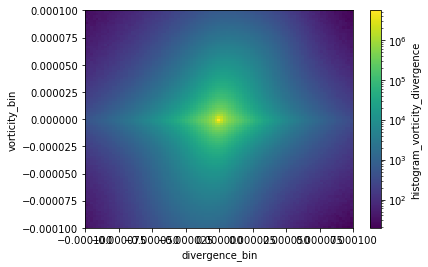

In [36]:
from matplotlib.colors import LogNorm
vort_div_hist.mean(dim='time').plot(norm=LogNorm())

In [13]:
import zarr
import gcsfs
gcs = gcsfs.GCSFileSystem(token='anon')
zgroup = zarr.open_consolidated(gcs.get_mapper("gcs://pangeo-data/llc4320_surface/U"))
list(zgroup.keys())

['U', 'face', 'i_g', 'j', 'time']

In [14]:
zgroup['U'].info

Name,/U
Type,zarr.core.Array
Data type,>f4
Shape,"(9030, 13, 4320, 4320)"
Chunk shape,"(1, 1, 4320, 4320)"
Order,C
Read-only,False
Compressor,"Blosc(cname='zstd', clevel=3, shuffle=BITSHUFFLE, blocksize=0)"
Store type,zarr.storage.ConsolidatedMetadataStore
Chunk store type,fsspec.mapping.FSMap
No. bytes,8763116544000 (8.0T)


In [44]:
ds.nbytes/1e9

9.704586384

In [8]:
# Note that we don't actually use this mask to subset the data.
# It turns out that the additional complexity involved in masking is greater than the
# overhead of just computing the FFT for the land points!
mask = ((ds_grid.hFacW.rename({'i_g': 'i'}) == 1) &
        (ds_grid.hFacS.rename({'j_g': 'j'}) == 1)
       ).rename('mask')
mask

<xarray.DataArray 'mask' (face: 13, j: 4320, i: 4320)>
dask.array<shape=(13, 4320, 4320), dtype=bool, chunksize=(1, 4320, 4320)>
Coordinates:
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
  * i        (i) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319
  * j        (j) int64 0 1 2 3 4 5 6 7 ... 4313 4314 4315 4316 4317 4318 4319

### Reshape and Rechunk Data

Here I take the 4D (time, face, j, i) data and turn it into a 2D dataset with dimensions (time, point).
Then I subset only the wet points.
Then I chunk the dataset into manageable pieces. Each of these chunks will be used for an individual in-memory FFT calculation.

In [24]:
24*180

4320

In [18]:
# full dataset is too big, and there is lots of redundant information
# we don't need to process every single grid point to get good spectra
subset_factor = 8

ds_subset = (xr.merge([ds_grid.reset_coords()[['XC', 'YC','CS', 'SN']],
                       mask,
                       ds_uv])
               .isel(j=slice(0 ,None, subset_factor),
                     i=slice(0, None, subset_factor), 
                     time=slice(0, 8640)) # get exactly 360 days
               .stack(point=['face', 'j', 'i'])
               .chunk({'time': 24*60, 'point': 500000})) # chunk it into 60 day segments
ds_subset

distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)


<xarray.Dataset>
Dimensions:  (point: 3790800, time: 8640)
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-06T23:00:00
  * point    (point) MultiIndex
  - face     (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  - j        (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  - i        (point) int64 0 8 16 24 32 40 48 56 ... 184 192 200 208 216 224 232
Data variables:
    XC       (point) float32 dask.array<shape=(3790800,), chunksize=(500000,)>
    YC       (point) float32 dask.array<shape=(3790800,), chunksize=(500000,)>
    CS       (point) float32 dask.array<shape=(3790800,), chunksize=(500000,)>
    SN       (point) float32 dask.array<shape=(3790800,), chunksize=(500000,)>
    mask     (point) bool dask.array<shape=(3790800,), chunksize=(500000,)>
    U        (time, point) float32 dask.array<shape=(8640, 3790800), chunksize=(1440, 500000)>
    V        (time, point) float32 dask.array<shape=(8640, 3790800), chunksize=(

Define complex velocity

$$ Z = u + i v $$

On the LLC grid, U and V don't represent the actual zonal / meridional velocity. They are components of a vector in the curvilinear model space. Originally I thought I had to project the vectors into zonal / meridional basis, but then I realized this step was unnecessary. As long as the vectors have the correct relationship (i.e. v is 90 degrees to the left of u), then the calculation comes out fine.

In [19]:
# Rotating vectors is not necessary as long as the U, V components have a consistent relationship

Z = ds_subset.U + 1j*ds_subset.V
Z

<xarray.DataArray (time: 8640, point: 3790800)>
dask.array<shape=(8640, 3790800), dtype=complex64, chunksize=(1440, 500000)>
Coordinates:
  * time     (time) datetime64[ns] 2011-09-13 ... 2012-09-06T23:00:00
  * point    (point) MultiIndex
  - face     (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  - j        (point) int64 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0
  - i        (point) int64 0 8 16 24 32 40 48 56 ... 184 192 200 208 216 224 232

### Use xrft to take power spectrum

You need the latest version of our [xrft](https://xrft.readthedocs.io/en/latest/) package for this to work. You can get it by running

    pip install --user git+https://github.com/xgcm/xrft.git

In [20]:
Z_ps = xrft.power_spectrum(Z, dim=['time'],
                           window=True, detrend='constant',
                           chunks_to_segments=True)
Z_ps

<xarray.DataArray 'rechunk-merge-ddeea9f2d9062e839a2a403262f2e83f' (time_segment: 6, freq_time: 1440, point: 3790800)>
dask.array<shape=(6, 1440, 3790800), dtype=float64, chunksize=(1, 1440, 500000)>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2 3 4 5
  * freq_time          (freq_time) float64 -0.0001389 -0.0001387 ... 0.0001387
  * point              (point) object (0, 0, 0) (0, 0, 8) ... (12, 4312, 4312)
    freq_time_spacing  float64 1.929e-07

### Take the Zonal Mean

Here we use `groupby_bins` to sort the points into latitude bins.

In [21]:
Z_ps_zonmean = (Z_ps.groupby_bins(ds_subset['YC'], np.arange(-81, 82, 2), labels=np.arange(-80, 81, 2))
                    .mean(dim=['time_segment', 'point']))
Z_ps_zonmean

<xarray.DataArray 'rechunk-merge-ddeea9f2d9062e839a2a403262f2e83f' (freq_time: 1440, YC_bins: 81)>
dask.array<shape=(1440, 81), dtype=float64, chunksize=(1440, 1)>
Coordinates:
  * YC_bins            (YC_bins) int64 -80 -78 -76 -74 -72 ... 72 74 76 78 80
  * freq_time          (freq_time) float64 -0.0001389 -0.0001387 ... 0.0001387
    freq_time_spacing  float64 1.929e-07

### Do the Computation

It takes ~3 minutes for dask to chew on the graph before sending it to the scheduler. That's because it has millions of tasks.

In [25]:
print(len(Z_ps_zonmean.data.dask))
%time Z_ps_zonmean_p = Z_ps_zonmean.persist(retries=10)

1382322


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


CPU times: user 4min 15s, sys: 11.9 s, total: 4min 27s
Wall time: 4min 20s


distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

In [16]:
ds_U.nbytes/1e9

8763.116685464

distributed.utils_perf - WARNING - full garbage collections took 23% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 26% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)


Watch the scheduler while this is happening. It takes a while.

### Make the plot


In [16]:
# make sure the data is memory
Z_ps_zonmean_p = Z_ps_zonmean_p.load()

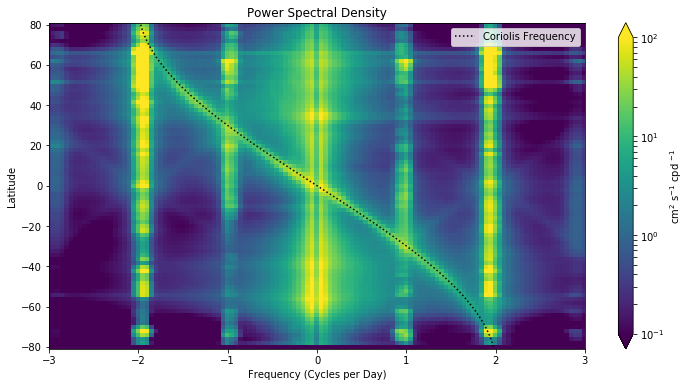

In [17]:
day = 24*60*60
Z_ps_zonmean_p.coords['freq_cycles_per_day'] = Z_ps_zonmean_p.freq_time * day
Z_ps_zonmean_p.coords['freq_cycles_per_day'].attrs['units'] = 'cycles per day'
# original units are m2/s2 / (cycles per s) = m2 s / (cycles s^2)
# want (cm2 / s2) / (cycles per day) = cm2 day / (cycles s^2)
# 100 cm / m
# 24*60*60 days / s
scale_fac =  day / (10000)

ps_to_plot = scale_fac * Z_ps_zonmean_p.swap_dims({'freq_time': 'freq_cycles_per_day'})
ps_to_plot = ps_to_plot.rename(r'cm$^2$ s$^{-1}$ cpd $^{-1}$')

omega = 7.2921e-5
f_coriolis = (2*omega*np.sin(np.deg2rad(ps_to_plot.YC_bins))) * day / (2*np.pi)

from matplotlib.colors import LogNorm
ps_to_plot.transpose().plot(figsize=(12,6), cmap='viridis', norm=LogNorm(), vmin=1e-1, vmax=1e2)
(-f_coriolis).plot.line(y='YC_bins', color='k', linestyle=':')
plt.xlim([-3, 3])
plt.xlabel('Frequency (Cycles per Day)')
plt.ylabel('Latitude')
plt.title('Power Spectral Density')
plt.legend(['Coriolis Frequency'])

### Comparison

With [Elipot et al. (2016)](https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2016JC011716)

![elipot figure](https://wol-prod-cdn.literatumonline.com/cms/attachment/ef844337-2142-4734-822f-f6e723ea9396/jgrc21689-fig-0017-m.jpg)